In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2025-09-05 12:11:07--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.008s  

2025-09-05 12:11:07 (6.02 MB/s) - ‘insurance.csv’ saved [50264/50264]



age     sex   bmi  children smoker     region  expenses
1333   50    male  31.0         3     no  northwest  10600.55
1334   18  female  31.9         0     no  northeast   2205.98
1335   18  female  36.9         0     no  southeast   1629.83
1336   21  female  25.8         0     no  southwest   2007.95
1337   61  female  29.1         0    yes  northwest  29141.36

**1) Preprocess data**

In [13]:
# Convert categorical columns to numbers (if not already done)
if dataset['sex'].dtype == 'object':
    dataset['sex'] = dataset['sex'].map({'male': 1, 'female': 0})
if dataset['smoker'].dtype == 'object':
    dataset['smoker'] = dataset['smoker'].map({'yes': 1, 'no': 0})

# Skip region encoding since it's already one-hot encoded
# Add extra features only if they don't already exist
if 'bmi_smoker' not in dataset.columns:
    dataset['bmi_smoker'] = dataset['bmi'] * dataset['smoker']
if 'age_bmi' not in dataset.columns:
    dataset['age_bmi'] = dataset['age'] * dataset['bmi']

dataset.head()


age  sex   bmi  children  smoker  expenses  region_northwest  \
0   19  NaN  27.9         0     NaN  16884.92             False   
1   18  NaN  33.8         1     NaN   1725.55             False   
2   28  NaN  33.0         3     NaN   4449.46             False   
3   33  NaN  22.7         0     NaN  21984.47              True   
4   32  NaN  28.9         0     NaN   3866.86              True   

   region_southeast  region_southwest  bmi_smoker  age_bmi  
0             False              True        27.9    530.1  
1              True             False         0.0    608.4  
2              True             False         0.0    924.0  
3             False             False         0.0    749.1  
4             False             False         0.0    924.8

In [12]:
dataset.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'expenses',
       'region_northwest', 'region_southeast', 'region_southwest',
       'bmi_smoker', 'age_bmi'],
      dtype='object')

**2) Split into train/test and pop labels**

In [14]:
from sklearn.model_selection import train_test_split

# Split 80% train, 20% test
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Pop labels (expenses) from each
train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

print("Train shape:", train_dataset.shape)
print("Test shape:", test_dataset.shape)


Train shape: (1070, 10)
Test shape: (268, 10)


**3) Normalize features**

In [15]:
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_dataset))


**4) Build and train the model**

In [16]:
def build_model(norm_layer):
    model = keras.Sequential([
        norm_layer,
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

model = build_model(normalizer)
model.summary()

# Train with early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_mae', patience=25, restore_best_weights=True)

history = model.fit(
    train_dataset, train_labels,
    validation_split=0.2,
    epochs=400,
    batch_size=32,
    verbose=2,
    callbacks=[early_stop]
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (1070, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21 (88.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21 (88.00 B)

Epoch 1/400
27/27 - 3s - 116ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/400
27/27 - 0s - 6ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/400
27/27 - 0s - 6ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/400
27/27 - 0s - 11ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 5/400
27/27 - 0s - 5ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 6/400
27/27 - 0s - 6ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 7/400
27/27 - 0s - 10ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 8/400
27/27 - 0s - 5ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 9/400
27/27 - 0s - 12ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan

9/9 - 0s - 6ms/step - loss: nan - mae: nan - mse: nan
Testing set Mean Abs Error:   nan expenses
The Mean Abs Error must be less than 3500. Keep trying.
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


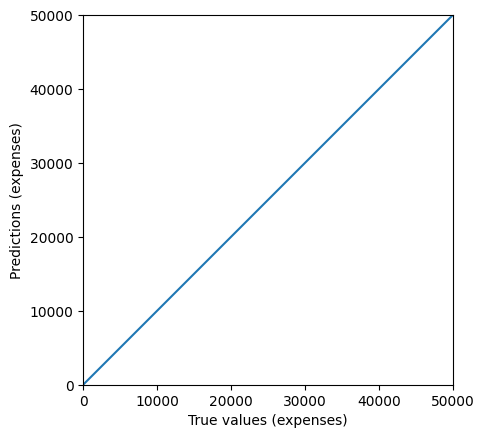

In [17]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
